### Creating the auxiliary input images

In [5]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import sys
sys.path.append('..')
from Workflow import Workflow
from glob import glob

In [6]:
wf = Workflow()
X_train,y_train, X_val, y_val, X_test, y_test = wf.load_data()

In [24]:
print(np.shape(X_train))
print(np.shape(y_test))

(78854, 10)
(9857,)


In [8]:
# # Extract the reprojected coordinates and store them

#train
geometry_train = [Point(xy) for xy in zip(X_train['lon'], X_train['lat'])]
Xtrain_gdf = gpd.GeoDataFrame(X_train, geometry=geometry_train, crs="EPSG:3577")  # WGS84 (lat/lon)

Xtrain_gdf['x'] = Xtrain_gdf.geometry.x
Xtrain_gdf['y'] = Xtrain_gdf.geometry.y

#validation
geometry_val = [Point(xy) for xy in zip(X_val['lon'], X_val['lat'])]
Xval_gdf = gpd.GeoDataFrame(X_val, geometry=geometry_val, crs="EPSG:3577")  # WGS84 (lat/lon)

Xval_gdf['x'] = Xval_gdf.geometry.x
Xval_gdf['y'] = Xval_gdf.geometry.y

#test
geometry_test = [Point(xy) for xy in zip(X_test['lon'], X_test['lat'])]
Xtest_gdf = gpd.GeoDataFrame(X_test, geometry=geometry_test, crs="EPSG:3577")  # WGS84 (lat/lon)

Xtest_gdf['x'] = Xtest_gdf.geometry.x
Xtest_gdf['y'] = Xtest_gdf.geometry.y

In [30]:
# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)

# 1. Load Rain Data
def load_data(filepath):
    with rasterio.open(filepath) as src:
        values = src.read(1)  # Load the first band
        transform = src.transform
    return values, transform

# 2. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, values, transform, size=32):
    rows, cols = values.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)

        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = values[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# 3. Load the recharge data
directory_path = r"./aux_inputs"
# List all .tif files in the directory
tif_files = glob(os.path.join(directory_path, "*.tif"))
columns_list = []
def centered_img(data):
    for file_path in tif_files:
        print(f"Processing file: {file_path}")

        # Load the data
        values, transform = load_data(file_path)

        # Extract the centered images
        imgs_ann = extract_sample_centered_images(data, values, transform)

        # Append the result to the list
        columns_list.append(imgs_ann)
    all_imgs_ann = list(zip(*columns_list))
    columns_list.clear()
    return all_imgs_ann 

# Use the updated coordinates
imgs_ann_train = centered_img(Xtrain_gdf)
imgs_ann_val = centered_img(Xval_gdf)
imgs_ann_test = centered_img(Xtest_gdf)

Processing file: ./aux_inputs\rainfall_raster_bound.tif
Processing file: ./aux_inputs\rainfall_raster_bound.tif
Processing file: ./aux_inputs\rainfall_raster_bound.tif


In [31]:
np.shape(imgs_ann_test)

(9857, 1, 32, 32)

#### Checking the centered images

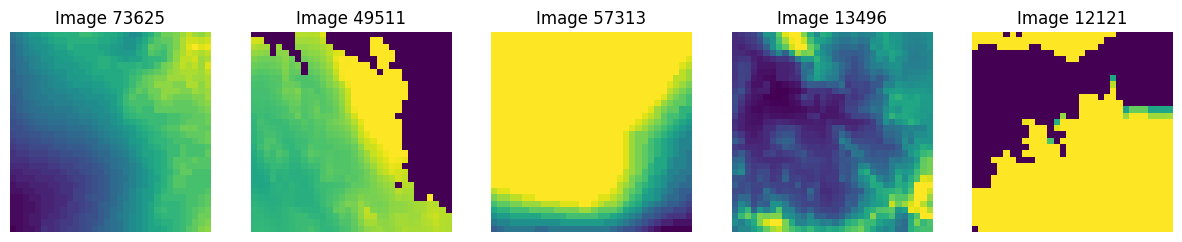

In [32]:
n = 5

# Select random images or specific indices
indices = np.random.choice(len(imgs_ann_train), n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(imgs_ann_train[idx][0], cmap="viridis")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Creating the location input

In [33]:
#normalizing the location input
def norm_loc(data):
    data.to_numpy()
    mean = (X_train.to_numpy()).mean(axis=0)
    std = (X_train.to_numpy()).std(axis=0)
    return ((data - mean)/std)

In [34]:
X_train = norm_loc(X_train)
X_val = norm_loc(X_val)
X_test = norm_loc(X_test)

In [35]:
np.shape(y_test)

(9857,)

In [36]:
#normalizing the images
def norm_loc(data):
    data = np.array(data)
    return ((data - data.mean())/data.std())

In [37]:
imgs_ann_train = norm_loc(imgs_ann_train)
imgs_ann_val = norm_loc(imgs_ann_val)
imgs_ann_test = norm_loc(imgs_ann_test)

### Our network

In [67]:
# Use neural network to learn relationship between terrain features and geochemistry ####

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.metrics import MeanSquaredError

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

x_train = [imgs_ann_train.reshape(-1, 32, 32, 1),X_train]
x_val = [imgs_ann_val.reshape(-1, 32, 32, 1),X_val]
x_test = [imgs_ann_test.reshape(-1, 32, 32, 1),X_test]

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(32, 32, 1), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(10,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = tf.keras.layers.Lambda(lambda x: x[:, 0:1])(main_output)


In [68]:
# Define the model
model = models.Model(inputs=[conv_input, auxiliary_input], outputs=main_output)
def custom_mse_loss(y_true, y_pred):
    # Extract the mean from the output
    mean = y_pred[:, 0]
    # Compute the mean squared error with the true values
    return tf.reduce_mean(tf.square(y_true - mean))
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), 
              loss='mse',
    metrics=[MeanSquaredError()])

# Summary of the model
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 10, 10, 128)  1280        conv_input[0][0]                 
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 10, 10, 128)  0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_20 (SpatialDr (None, 10, 10, 128)  0           activation_35[0][0]              
______________________________________________________________________________________

In [69]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [70]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.3.0


In [72]:
# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 10
epochs = 10

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

# Save and load model weights
model.save_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))
model.load_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))

# Create a new model for predictions using the 'dist_param' layer
meanmodel = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("dist_param").output
)

# Save and load the mean model
meanmodel.save(os.path.join(os.getcwd(), "models/meanmodel.h5"))
meanmodel = tf.keras.models.load_model(os.path.join(os.getcwd(), "models/meanmodel.h5"))

# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': meanmodel.predict(x_test)[:, 0]})

# Calculate and print R squared and RMSE
print(f"R squared = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")


Epoch 1/10


KeyboardInterrupt: 

In [57]:
np.shape(imgs_ann_train)

(78854, 1, 32, 32)

In [75]:
# Calculate and print R² score using numpy's corrcoef
try:
	r2_score = np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2
	print(f"R² Score: {r2_score:.3f}")
except Exception as e:
	print(f"Error calculating R² score: {e}")

R² Score: nan


In [59]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [60]:

# Plot observed vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x='obs', y='preds', data=holdout, alpha=0.1)
plt.plot([holdout['obs'].min(), holdout['obs'].max()], [holdout['obs'].min(), holdout['obs'].max()], 'k--')
plt.xlabel(f"Observed log({elem})" if logtrans else f"observed {elem}")
plt.ylabel(f"Predicted log({elem})" if logtrans else f"predicted {elem}")
plt.title(f"R² = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)}     RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 2)}")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"plots/{elem}_mean_holdout_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)

# Prepare training history data for plotting
trainhist = pd.DataFrame(history.history)[['loss', 'val_loss']]
trainhist.columns = ['training', 'testing']
trainhist['epoch'] = range(1, len(trainhist) + 1)

# Melt the training history data for plotting
trainhist_melted = trainhist.melt(id_vars='epoch', var_name='dataset', value_name='NLL')

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='NLL', hue='dataset', data=trainhist_melted)
plt.ylim(0, trainhist['testing'].quantile(0.999))
plt.savefig(f"plots/{elem}_training_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)


ModuleNotFoundError: No module named 'seaborn'